In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import datetime 
from geopy import distance
import folium
from folium.plugins import MarkerCluster
from folium.features import GeoJsonTooltip
from branca.colormap import LinearColormap
from collections import Counter
import geopy.distance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


In [2]:
Capital_bike_share = pd.read_csv('dc_bikes_sample_3000.csv', sep=',')

In [3]:
Capital_bike_share.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'time_of_day', 'duration_hours', 'Date_year',
       'Date_day', 'Date_dow_name', 'Date_month_name', 'Date_month_no', 'day',
       'dow', 'weekend', 'Season', 'ride_count', 'hour', 'Minute', 'time'],
      dtype='object')

In [4]:
# Convert started_at and ended_at to datetime for memory efficiency
Capital_bike_share['started_at'] = pd.to_datetime(Capital_bike_share['started_at'])
Capital_bike_share['ended_at'] = pd.to_datetime(Capital_bike_share['ended_at'])

In [5]:
# Calculate ride duration in hours
Capital_bike_share['duration_hours'] = (Capital_bike_share['ended_at'] - Capital_bike_share['started_at']).dt.total_seconds() / 3600

# Define the Haversine function
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth using the Haversine formula.
    Inputs:
    - lat1, lon1: Latitude and longitude of point 1 in degrees.
    - lat2, lon2: Latitude and longitude of point 2 in degrees.
    Output:
    - Distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

In [6]:
# Calculate distance for each ride
Capital_bike_share['distance_km'] = Capital_bike_share.apply(
    lambda row: haversine(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']),
    axis=1
)

# Calculate speed in km/h
Capital_bike_share['speed_kmh'] = Capital_bike_share['distance_km'] / Capital_bike_share['duration_hours']

In [7]:
# --- Step 1: Convert 'started_at' and 'ended_at' to datetime format ---
Capital_bike_share['started_at'] = pd.to_datetime(Capital_bike_share['started_at'])
Capital_bike_share['ended_at'] = pd.to_datetime(Capital_bike_share['ended_at'])

# --- Step 2: Calculate ride duration in minutes ---
Capital_bike_share['ride_duration'] = (Capital_bike_share['ended_at'] - Capital_bike_share['started_at']).dt.total_seconds() / 60  # Convert to minutes

# Display the updated DataFrame
print(Capital_bike_share)

        ride_id  rideable_type          started_at            ended_at  \
0        3363.0   classic_bike 2021-01-02 13:56:30 2021-01-02 14:02:06   
1       97357.0    docked_bike 2021-01-30 15:34:48 2021-01-30 17:05:41   
2       46177.0   classic_bike 2021-01-15 07:11:24 2021-01-15 07:13:20   
3       95158.0   classic_bike 2021-01-30 06:49:29 2021-01-30 06:54:30   
4       41194.0   classic_bike 2021-01-13 17:42:09 2021-01-13 17:46:28   
...         ...            ...                 ...                 ...   
107995      NaN   classic_bike 2023-12-17 13:55:51 2023-12-17 14:01:24   
107996      NaN   classic_bike 2023-12-09 09:44:07 2023-12-09 09:55:03   
107997      NaN  electric_bike 2023-12-04 23:03:13 2023-12-04 23:21:05   
107998      NaN   classic_bike 2023-12-11 09:23:48 2023-12-11 09:27:21   
107999      NaN  electric_bike 2023-12-13 17:28:45 2023-12-13 17:41:42   

                                  start_station_name  start_station_id  \
0                                    

In [8]:
Capital_bike_share.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'time_of_day', 'duration_hours', 'Date_year',
       'Date_day', 'Date_dow_name', 'Date_month_name', 'Date_month_no', 'day',
       'dow', 'weekend', 'Season', 'ride_count', 'hour', 'Minute', 'time',
       'distance_km', 'speed_kmh', 'ride_duration'],
      dtype='object')

In [9]:
Capital_bike_share['Season'].unique

<bound method Series.unique of 0         winter
1         winter
2         winter
3         winter
4         winter
           ...  
107995    winter
107996    winter
107997    winter
107998    winter
107999    winter
Name: Season, Length: 108000, dtype: object>

In [10]:

# --- Step 1: Count the Number of Rides from Each Start Station (Proxy for Availability) ---
bike_availability = Capital_bike_share['start_station_name'].value_counts().reset_index()
bike_availability.columns = ['start_station_name', 'bike_availability_start']

# --- Step 2: Merge Availability Data into the Original DataFrame ---
Capital_bike_share = Capital_bike_share.merge(bike_availability, on='start_station_name', how='left')

# --- Display the Updated DataFrame ---
print(Capital_bike_share)

        ride_id  rideable_type          started_at            ended_at  \
0        3363.0   classic_bike 2021-01-02 13:56:30 2021-01-02 14:02:06   
1       97357.0    docked_bike 2021-01-30 15:34:48 2021-01-30 17:05:41   
2       46177.0   classic_bike 2021-01-15 07:11:24 2021-01-15 07:13:20   
3       95158.0   classic_bike 2021-01-30 06:49:29 2021-01-30 06:54:30   
4       41194.0   classic_bike 2021-01-13 17:42:09 2021-01-13 17:46:28   
...         ...            ...                 ...                 ...   
107995      NaN   classic_bike 2023-12-17 13:55:51 2023-12-17 14:01:24   
107996      NaN   classic_bike 2023-12-09 09:44:07 2023-12-09 09:55:03   
107997      NaN  electric_bike 2023-12-04 23:03:13 2023-12-04 23:21:05   
107998      NaN   classic_bike 2023-12-11 09:23:48 2023-12-11 09:27:21   
107999      NaN  electric_bike 2023-12-13 17:28:45 2023-12-13 17:41:42   

                                  start_station_name  start_station_id  \
0                                    

In [11]:
Capital_bike_share['bike_availability_start'].head(10)

0    1094
1    1112
2     764
3     430
4      84
5     610
6     123
7     926
8     435
9     174
Name: bike_availability_start, dtype: int64

# Multivariate LR

In [12]:
Capital_bike_share.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'time_of_day', 'duration_hours', 'Date_year',
       'Date_day', 'Date_dow_name', 'Date_month_name', 'Date_month_no', 'day',
       'dow', 'weekend', 'Season', 'ride_count', 'hour', 'Minute', 'time',
       'distance_km', 'speed_kmh', 'ride_duration', 'bike_availability_start'],
      dtype='object')

In [13]:
Capital_bike_share['Date_dow_name'].head(10)

0     Saturday
1     Saturday
2       Friday
3     Saturday
4    Wednesday
5       Monday
6     Thursday
7       Sunday
8      Tuesday
9     Saturday
Name: Date_dow_name, dtype: object

In [14]:
print(Capital_bike_share.shape)  # Check if dataset has rows
print(Capital_bike_share.head())  # Show first few rows

(108000, 32)
   ride_id rideable_type          started_at            ended_at  \
0   3363.0  classic_bike 2021-01-02 13:56:30 2021-01-02 14:02:06   
1  97357.0   docked_bike 2021-01-30 15:34:48 2021-01-30 17:05:41   
2  46177.0  classic_bike 2021-01-15 07:11:24 2021-01-15 07:13:20   
3  95158.0  classic_bike 2021-01-30 06:49:29 2021-01-30 06:54:30   
4  41194.0  classic_bike 2021-01-13 17:42:09 2021-01-13 17:46:28   

                 start_station_name  start_station_id  \
0                    15th & P St NW           31201.0   
1                  Lincoln Memorial           31258.0   
2                    11th & M St NW           31266.0   
3                    12th & L St NW           31251.0   
4  King St Metro North / Cameron St           31098.0   

                            end_station_name  end_station_id  start_lat  \
0              20th & O St NW / Dupont South         31234.0  38.909868   
1                              4th & M St SE         31652.0  38.888255   
2         

In [15]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
label_encoder = LabelEncoder()

# Encode categorical columns
Capital_bike_share['start_station_name_encoded'] = label_encoder.fit_transform(Capital_bike_share['start_station_name'])
Capital_bike_share['end_station_name_encoded'] = label_encoder.fit_transform(Capital_bike_share['end_station_name'])
Capital_bike_share['time_of_day_encoded'] = label_encoder.fit_transform(Capital_bike_share['time_of_day'])

print(Capital_bike_share.head())  # Confirm the new encoded columns exist

   ride_id rideable_type          started_at            ended_at  \
0   3363.0  classic_bike 2021-01-02 13:56:30 2021-01-02 14:02:06   
1  97357.0   docked_bike 2021-01-30 15:34:48 2021-01-30 17:05:41   
2  46177.0  classic_bike 2021-01-15 07:11:24 2021-01-15 07:13:20   
3  95158.0  classic_bike 2021-01-30 06:49:29 2021-01-30 06:54:30   
4  41194.0  classic_bike 2021-01-13 17:42:09 2021-01-13 17:46:28   

                 start_station_name  start_station_id  \
0                    15th & P St NW           31201.0   
1                  Lincoln Memorial           31258.0   
2                    11th & M St NW           31266.0   
3                    12th & L St NW           31251.0   
4  King St Metro North / Cameron St           31098.0   

                            end_station_name  end_station_id  start_lat  \
0              20th & O St NW / Dupont South         31234.0  38.909868   
1                              4th & M St SE         31652.0  38.888255   
2          Convention C

In [16]:
print(Capital_bike_share.shape)  # Check if dataframe has rows
if Capital_bike_share.shape[0] == 0:
    raise ValueError("🚨 Error: Dataset is empty after filtering!")

(108000, 35)


In [17]:
# --- Step 2: Filter for electric bikes in Spring ---
df_spring = Capital_bike_share[(Capital_bike_share['rideable_type'] == 'electric_bike') & (Capital_bike_share['Season'] == 'spring')]

# --- Step 3: Encode categorical variables ---
label_encoder = LabelEncoder()
df_spring['start_station_name_encoded'] = label_encoder.fit_transform(df_spring['start_station_name'])
df_spring['end_station_name_encoded'] = label_encoder.fit_transform(df_spring['end_station_name'])
df_spring['time_of_day_encoded'] = label_encoder.fit_transform(df_spring['time_of_day'])

# --- Step 4: Select Features and Target Variable ---
X = df_spring[['bike_availability_start', 'distance_km', 'start_station_name_encoded', 
               'end_station_name_encoded', 'time_of_day_encoded', 'Date_dow_name']]
y = df_spring['ride_count']  # Target: Predict ride demand

In [18]:
Capital_bike_share.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'time_of_day', 'duration_hours', 'Date_year',
       'Date_day', 'Date_dow_name', 'Date_month_name', 'Date_month_no', 'day',
       'dow', 'weekend', 'Season', 'ride_count', 'hour', 'Minute', 'time',
       'distance_km', 'speed_kmh', 'ride_duration', 'bike_availability_start',
       'start_station_name_encoded', 'end_station_name_encoded',
       'time_of_day_encoded'],
      dtype='object')

In [19]:
X = Capital_bike_share[['bike_availability_start', 'distance_km', 'start_station_name_encoded', 'end_station_name_encoded', 'time_of_day_encoded']]
y = Capital_bike_share['ride_count']

print("X shape:", X.shape)  # Should not be (0, n)
print("y shape:", y.shape)  # Should not be (0,)

X shape: (108000, 5)
y shape: (108000,)


In [20]:
print(f"df shape: {Capital_bike_share.shape}")

df shape: (108000, 35)


In [21]:
if Capital_bike_share.shape[0] == 0:
    raise ValueError("🚨 Error: DataFrame is empty after filtering. Check data preprocessing!")

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (86400, 5), X_test shape: (21600, 5)


In [23]:
if X_train.shape[0] > 0 and X_test.shape[0] > 0:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
else:
    raise ValueError("🚨 Error: No data available after train-test split!")

In [24]:
Capital_bike_share.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'time_of_day', 'duration_hours', 'Date_year',
       'Date_day', 'Date_dow_name', 'Date_month_name', 'Date_month_no', 'day',
       'dow', 'weekend', 'Season', 'ride_count', 'hour', 'Minute', 'time',
       'distance_km', 'speed_kmh', 'ride_duration', 'bike_availability_start',
       'start_station_name_encoded', 'end_station_name_encoded',
       'time_of_day_encoded'],
      dtype='object')

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [26]:
Capital_bike_share.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'time_of_day', 'duration_hours', 'Date_year',
       'Date_day', 'Date_dow_name', 'Date_month_name', 'Date_month_no', 'day',
       'dow', 'weekend', 'Season', 'ride_count', 'hour', 'Minute', 'time',
       'distance_km', 'speed_kmh', 'ride_duration', 'bike_availability_start',
       'start_station_name_encoded', 'end_station_name_encoded',
       'time_of_day_encoded'],
      dtype='object')

Mean Squared Error: 309.0983727072492
R-squared: 0.010869509181392178


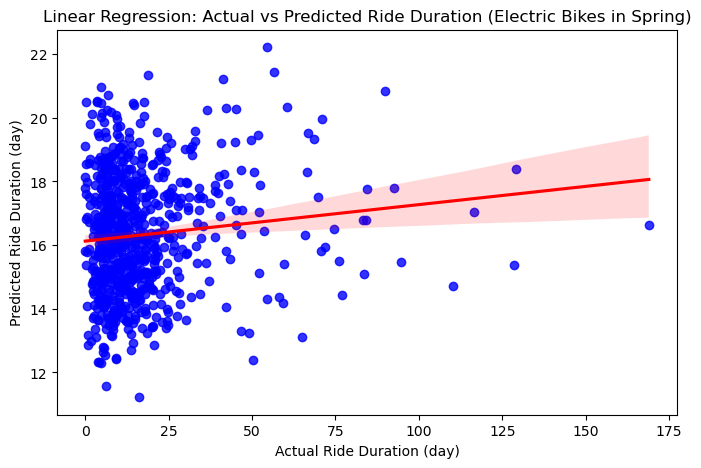

In [99]:
# --- Step 1: Filter only electric bike rides in Spring ---
Capital_bike_share = Capital_bike_share[(Capital_bike_share['rideable_type'] == 'electric_bike') & (Capital_bike_share['Season'] == 'Spring')]

# --- Step 2: Encode categorical station data ---
label_encoder = LabelEncoder()
Capital_bike_share['start_station_encoded'] = label_encoder.fit_transform(Capital_bike_share['start_station_name'])
Capital_bike_share['end_station_encoded'] = label_encoder.fit_transform(Capital_bike_share['end_station_name'])

# --- Step 3: Select features and target variable ---
X = Capital_bike_share[['dow', 'bike_availability_start', 'start_station_encoded', 'end_station_encoded']]  # Features
y = Capital_bike_share['ride_duration']  # Target variable (predicting ride duration)

# --- Step 4: Split into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 5: Train the Linear Regression model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Step 6: Make predictions ---
y_pred = model.predict(X_test)

# --- Step 7: Evaluate model performance ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# --- Step 8: Visualize results ---
plt.figure(figsize=(8, 5))
sns.regplot(x=y_test, y=y_pred, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel("Actual Ride Duration (day)")
plt.ylabel("Predicted Ride Duration (day)")
plt.title("Linear Regression: Actual vs Predicted Ride Duration (Electric Bikes in Spring)")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Generate some sample data
np.random.seed(42)
num_points = 20
x=10*np.random.normal(0,1,num_points)
y=10*(x**2)+np.random.normal(-400,400,num_points)

# Function to fit and plot polynomial regression
def plot_polynomial_regression(degree):
    coefficients = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coefficients)
    y_pred = polynomial(x)

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label="Data")
    plt.plot(np.sort(x), y_pred[np.argsort(x)], color='red', label="Polynomial Regression (Degree {})".format(degree))
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Polynomial Regression")

# Create an interactive widget for degree selection
degree_slider = widgets.IntSlider(value=1, min=1, max=10, step=1, description='Degree')

# Create a function to update the plot when the slider is moved
def update_plot(change):
    clear_output()
    display(degree_slider, output)

degree_slider.observe(update_plot, 'value')

# Create an interactive output
output = widgets.interactive_output(plot_polynomial_regression, {'degree': degree_slider})

# Display the widgets and the output
display(degree_slider, output)

IntSlider(value=3, description='Degree', max=10, min=1)

Output()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


df_spring_electric = Capital_bike_share[
    (Capital_bike_share['rideable_type'] == 'electric_bike') & 
    (Capital_bike_share['Season'] == 'Spring')]

# Group by hour and calculate average bike availability
hourly_availability = df_spring_electric.groupby('day')['bike_availability_start'].mean().reset_index()

# Independent (X) and Dependent (Y) Variables
X = hourly_availability[['day']]
y = hourly_availability['bike_availability_start']

# Create an interactive polynomial regression plot
def plot_polynomial_regression(degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Train polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predict values
    y_pred = model.predict(X_poly)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X, y, label="Actual Data", color="blue")
    plt.plot(X, y_pred, color='red', label=f"Polynomial Regression (Degree {degree})")
    
    plt.legend()
    plt.xlabel("Day of the Week")
    plt.ylabel("Avg. Bike Availability")
    plt.title("Electric Bike Availability Prediction (Spring)")
    #plt.xticks(range(0, 7,1))
    plt.grid(True)
    plt.show()

# Create an interactive widget for degree selection
degree_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Degree')

# Output widget
output = widgets.Output()

# Function to update the plot dynamically
def update_plot(change):
    with output:
        clear_output(wait=True)
        plot_polynomial_regression(degree_slider.value)

# Observe slider value changes
degree_slider.observe(update_plot, names='value')

# Display the interactive widgets
display(degree_slider, output)

# Initial plot
update_plot(None)


IntSlider(value=2, description='Degree', max=10, min=1)

Output()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Filter dataset for Spring and electric bikes
df_spring_electric = Capital_bike_share[
    (Capital_bike_share['rideable_type'] == 'electric_bike') & 
    (Capital_bike_share['Season'] == 'Spring')
]

# Group by day and calculate average bike availability
hourly_availability = df_spring_electric.groupby('dow')['bike_availability_start'].mean().reset_index()

# Independent (X) and Dependent (Y) Variables
X = hourly_availability[['dow']]
y = hourly_availability['bike_availability_start']

# Create an interactive polynomial regression plot
def plot_polynomial_regression(degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Train polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predict values
    y_pred = model.predict(X_poly)

    # Compute Metrics
    mse = mean_squared_error(y, y_pred)
    r2 = model.score(X_poly, y)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X, y, label="Actual Data", color="blue")
    plt.plot(X, y_pred, color='red', label=f"Polynomial Regression (Degree {degree})")
    
    # Display metrics on the plot
    plt.text(0.05, 0.95, f'MSE: {mse:.2f}\nR²: {r2:.3f}', transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.7))

    plt.legend()
    plt.xlabel("Day of the Week")
    plt.ylabel("Avg. Bike Availability")
    plt.title("Electric Bike Availability Prediction (Spring)")
    plt.grid(True)
    plt.show()

# Create an interactive widget for degree selection
degree_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Degree')

# Output widget
output = widgets.Output()

# Function to update the plot dynamically
def update_plot(change):
    with output:
        clear_output(wait=True)
        plot_polynomial_regression(degree_slider.value)

# Observe slider value changes
degree_slider.observe(update_plot, names='value')

# Display the interactive widgets
display(degree_slider, output)

# Initial plot
update_plot(None)

IntSlider(value=2, description='Degree', max=10, min=1)

Output()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Filter dataset for Spring and electric bikes
df_spring_electric = Capital_bike_share[
    (Capital_bike_share['rideable_type'] == 'electric_bike') & 
    (Capital_bike_share['Season'] == 'Spring')
]

# Group by day and calculate average bike availability
hourly_availability = df_spring_electric.groupby('day')['bike_availability_start'].mean().reset_index()

# Independent (X) and Dependent (Y) Variables
X = hourly_availability[['day']]
y = hourly_availability['bike_availability_start']

# Function to fit polynomial regression and calculate metrics
def plot_polynomial_regression(degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Train polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predict values
    y_pred = model.predict(X_poly)

    # Compute Mean Squared Error and R-squared
    mse = mean_squared_error(y, y_pred)
    r2 = model.score(X_poly, y)

    # Determine model fit quality
    if r2 < 0.5:
        fit_quality = "Underfitting (Poor)"
        color = "red"
    elif 0.5 <= r2 <= 0.95:
        fit_quality = "Good Fit ✅"
        color = "green"
    else:
        fit_quality = "Overfitting (Too Complex)"
        color = "orange"

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X, y, label="Actual Data", color="blue")
    plt.plot(X, y_pred, color='red', label=f"Polynomial Regression (Degree {degree})")

    # Display MSE & R² on the plot
    plt.text(0.05, 0.95, f'MSE: {mse:.2f}\nR²: {r2:.3f}\n{fit_quality}', 
             transform=plt.gca().transAxes, fontsize=12, color=color,
             bbox=dict(facecolor='white', alpha=0.7))

    plt.legend()
    plt.xlabel("Day of the Week")
    plt.ylabel("Avg. Bike Availability")
    plt.title("Electric Bike Availability Prediction (Spring)")
    plt.grid(True)
    plt.show()

# Create an interactive widget for degree selection
degree_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Degree')

# Output widget
output = widgets.Output()

# Function to update the plot dynamically
def update_plot(change):
    with output:
        clear_output(wait=True)
        plot_polynomial_regression(degree_slider.value)

# Observe slider value changes
degree_slider.observe(update_plot, names='value')

# Display the interactive widgets
display(degree_slider, output)

# Initial plot
update_plot(None)


IntSlider(value=2, description='Degree', max=10, min=1)

Output()

In [93]:
Capital_bike_share.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'time_of_day', 'duration_hours', 'Date_year',
       'Date_day', 'Date_dow_name', 'Date_month_name', 'Date_month_no', 'day',
       'dow', 'weekend', 'Season', 'ride_count', 'hour', 'Minute', 'time',
       'distance_km', 'speed_kmh', 'ride_duration', 'bike_availability_start',
       'start_station_name_encoded', 'end_station_name_encoded',
       'time_of_day_encoded', 'start_station_encoded', 'end_station_encoded'],
      dtype='object')

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 📌 Load and filter dataset for Spring & electric bikes
df_spring_electric = Capital_bike_share[
    (Capital_bike_share['rideable_type'] == 'electric_bike') & 
    (Capital_bike_share['Season'] == 'Spring')
]

# 📌 Group by day and calculate average bike availability
hourly_availability = df_spring_electric.groupby('duration_hours')['bike_availability_start'].mean().reset_index()

# Independent (X) and Dependent (Y) Variables
X = hourly_availability[['duration_hours']]
y = hourly_availability['bike_availability_start']

# 📌 Function to fit polynomial regression and calculate metrics
def plot_polynomial_regression(degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Train polynomial regression model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predict values
    y_pred = model.predict(X_poly)

    # Compute Mean Squared Error and R-squared
    mse = mean_squared_error(y, y_pred)
    r2 = model.score(X_poly, y)

    # Determine model fit quality
    if r2 < 0.5:
        fit_quality = "Underfitting ❌"
        color = "red"
    elif 0.5 <= r2 <= 0.95:
        fit_quality = "Good Fit ✅"
        color = "green"
    else:
        fit_quality = "Overfitting ⚠️"
        color = "orange"

    # 📊 Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X, y, label="Actual Data", color="blue")
    plt.plot(X, y_pred, color='red', label=f"Polynomial Regression (Degree {degree})")

    # Display MSE & R² on the plot
    plt.text(0.05, 0.95, f'MSE: {mse:.2f}\nR²: {r2:.3f}\n{fit_quality}', 
             transform=plt.gca().transAxes, fontsize=12, color=color,
             bbox=dict(facecolor='white', alpha=0.7))

    plt.legend()
    plt.xlabel("Day of the Week")
    plt.ylabel("Avg. Bike Availability")
    plt.title("Electric Bike Availability Prediction (Spring)")
    plt.grid(True)
    plt.show()

# 📌 Interactive widget for degree selection
degree_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Degree')

# Output widget
output = widgets.Output()

# 📌 Function to update the plot dynamically
def update_plot(change):
    with output:
        clear_output(wait=True)
        plot_polynomial_regression(degree_slider.value)

# Observe slider value changes
degree_slider.observe(update_plot, names='value')

# Display the interactive widgets
display(degree_slider, output)

# Initial plot
update_plot(None)


IntSlider(value=2, description='Degree', max=10, min=1)

Output()